In [1]:
import os,sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
from torchvision import datasets, transforms
from core.data import DataGenerator,DatasetsDG
from core.models import SimpleNN,EnsembleModel, SimpleCNN
from core.cf_problem import make_cf_problem

from core.optimization import run_nsga, NSGAConfig, run_moc_nsga
from torch.utils.data import DataLoader, Dataset, TensorDataset
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch import nn

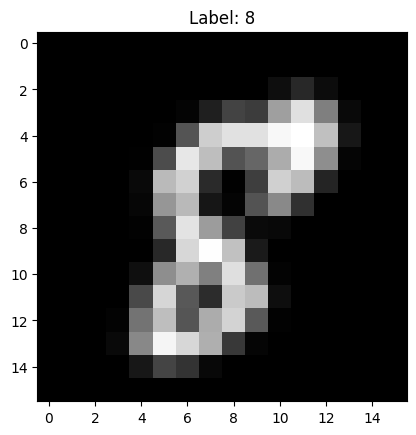

In [2]:
# load dataset and model
# Image size configuration - using 16x16 to reduce search space (256 vs 784 dimensions)
IMG_SIZE = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize from 28x28 to 16x16
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=False, download=True, transform=transform)

DG=DatasetsDG(train_dataset, num_classes=10)
models = [SimpleCNN(16,16,input_channels=1, num_classes=10) for _ in range(10)]


# show the first image in the training dataset
image, label = DG.sample(1, seed=44)
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(f'Label: {label.argmax().item()}')
plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model in models:
    model.to(device)

criterion = nn.CrossEntropyLoss()

epochs = 100
for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Create optimizer for each model
    seed = 42 + hash(model) % 1000  # Simple way to get different seeds
    samples = DG.sample(5000, seed=seed)
    model_train_dataset = TensorDataset(samples[0].to(device), samples[1].to(device))
    train_loader = DataLoader(model_train_dataset, batch_size=512, shuffle=True)  # Create loader inside loop
    model.train()
    bar = tqdm(range(epochs), desc="Training Model", colour="blue", unit="epoch")
    running_loss = 0.0
    for epoch in bar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.argmax(dim=1))  # labels are one-hot from DG.sample()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        bar.set_postfix(loss=running_loss/(epoch+1))

Training Model: 100%|██████████| 100/100 [00:06<00:00, 14.76epoch/s, loss=3.43]


Using EnsembleModel with 10 models
Objectives: [Validity, Epistemic, Sparsity, -AU]


(9, tensor([8], device='cuda:0'))

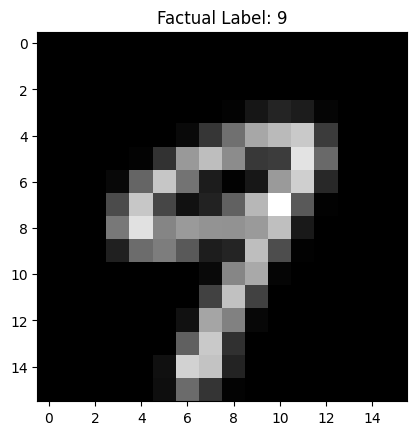

In [4]:
x_factual, y_factual = DG.sample(1, seed=1234)
plt.imshow(x_factual[0].squeeze(), cmap='gray')
plt.title(f'Factual Label: {y_factual.argmax().item()}')
target_class = 8  # Target class different from factual
target_class_tensor = torch.tensor([target_class], device=device)

# Create EnsembleModel to enable AU objective
ensemble = EnsembleModel(models)

# With ensemble: objectives are [Validity, Epistemic, Sparsity, -AU (neg to maximize AU)]
problem = make_cf_problem(models[0], x_factual, target_class_tensor, DG.sample(5000, seed=5678)[0], device=device, ensemble=ensemble)
print(f"Using EnsembleModel with {len(models)} models")
print("Objectives: [Validity, Epistemic, Sparsity, -AU]")
y_factual.argmax().item(), target_class_tensor

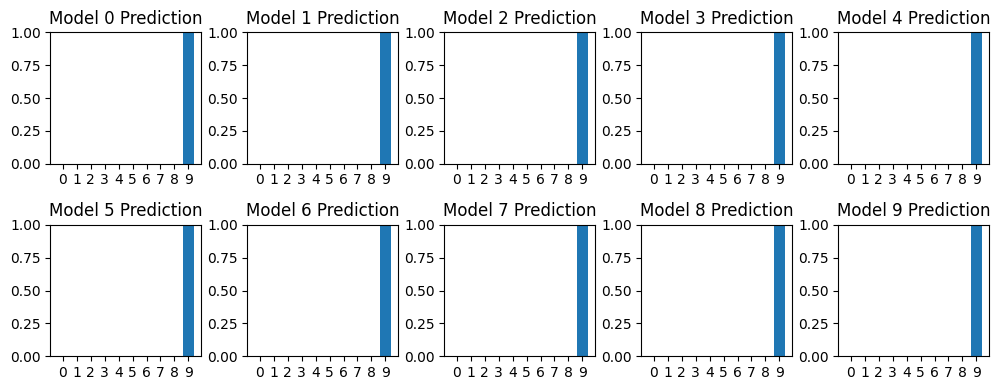

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
# visualize the each model's prediction on the factual instance using plt
plt.figure(figsize=(10, 4))
for i, model in enumerate(models):
    model.eval()
    probs=torch.zeros(10, device=device)
    with torch.no_grad():
        output = model(x_factual.to(device))
        probs += nn.functional.softmax(output, dim=1).squeeze()
    plt.subplot(2, 5, i+1)
    plt.bar(range(10), probs.cpu().numpy())
    plt.title(f'Model {i} Prediction')
    plt.xticks(range(10))
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()
print(probs.cpu().numpy().round(3))
        

In [6]:
from core.optimization import FactualBasedSampling
import importlib 
import core.optimization
import core.cf_problem
importlib.reload(core.cf_problem)
importlib.reload(core.optimization)
from core.cf_problem import make_cf_problem
from core.optimization import run_nsga, NSGAConfig, FactualBasedSampling

# Recreate problem with reloaded modules
problem = make_cf_problem(models[0], x_factual, target_class_tensor, DG.sample(5000, seed=5678)[0], device=device, ensemble=ensemble)
print(f"Problem type: {type(problem)}")

# Reduced population size to avoid memory issues with duplicate elimination
NSGA2_config = NSGAConfig(
    pop_size=200,                  # Reduced from 550 to avoid memory issues
    min_gen=200,
    max_gen=300,
    use_conditional_mutator=True,  # Enable MOC-style conditional mutator
    conditional_mutator_prob=0.7,  # 70% conditional, 30% polynomial mutation
    use_reset_operator=True,       # Enable MOC-style reset operator
    reset_prob=0.2,                # 20% probability of resetting each feature to factual
)

# Pass X_obs and x_factual for conditional mutator and reset operator
X_obs = DG.sample(5000, seed=5678)[0]
results = run_nsga(
    problem, 
    NSGA2_config, 
    sampling=FactualBasedSampling(x_star=x_factual, noise_scale=0.3, device=device),
    X_obs=X_obs,
    x_factual=x_factual,
    device=device
)

C:\Users\yuanl\AppData\Local\Temp\ipykernel_72640\1739826669.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  results = run_moc_nsga(x_star=x_factual, problem=problem, config=NSGA2_config, X_obs=torch.tensor(DG.sample(1000, seed=789)[0], dtype=torch.float32), device=device)


Problem type: <class 'core.cf_problem.TorchCFProblem'>
Gen    1 | Valid CFs (pop):   0 | Pareto front:  74 | Best P(target): 0.000 | Mean Sparsity: 158.554
Gen   10 | Valid CFs (pop):   0 | Pareto front: 200 | Best P(target): 0.000 | Mean Sparsity: 94.015
Gen   20 | Valid CFs (pop):   0 | Pareto front: 200 | Best P(target): 0.007 | Mean Sparsity: 80.860
Gen   30 | Valid CFs (pop):   0 | Pareto front: 200 | Best P(target): 0.146 | Mean Sparsity: 70.530
Gen   40 | Valid CFs (pop):   0 | Pareto front: 200 | Best P(target): 0.146 | Mean Sparsity: 65.545
Gen   50 | Valid CFs (pop):   0 | Pareto front: 200 | Best P(target): 0.146 | Mean Sparsity: 63.135
Gen   60 | Valid CFs (pop):   0 | Pareto front: 200 | Best P(target): 0.415 | Mean Sparsity: 59.390
Gen   70 | Valid CFs (pop):   0 | Pareto front: 200 | Best P(target): 0.415 | Mean Sparsity: 53.665
Gen   80 | Valid CFs (pop):   4 | Pareto front: 200 | Best P(target): 0.643 | Mean Sparsity: 55.720
Gen   90 | Valid CFs (pop):  20 | Pareto fro

In [7]:
# clear the GPU cache
torch.cuda.empty_cache()

In [8]:
# Option to continue training from previous results
CONTINUE_TRAINING = True  # Set to True to continue from previous results

if CONTINUE_TRAINING and 'results' in dir() and results is not None:
    print("Continuing training from previous results...")
    
    # Use the previous results as initial sampling with some noise
    # Create a new FactualBasedSampling but initialize from previous best solutions
    import numpy as np
    
    # Combine previous results with factual-based sampling
    prev_X = results.X.copy()
    
    NSGA2_continue_config = NSGAConfig(
        pop_size=min(len(prev_X), 550),  # Use size of previous results or max pop_size
        min_gen=1200,  # Fewer generations for continuation
        max_gen=1800,
        use_conditional_mutator=True,
        conditional_mutator_prob=0.7,
        use_reset_operator=True,
        reset_prob=0.2,
    )
    
    # Create sampling that uses previous results
    from pymoo.operators.sampling.rnd import FloatRandomSampling
    
    class PreviousResultsSampling(FloatRandomSampling):
        def __init__(self, prev_results, noise_scale=0.05):
            super().__init__()
            self.prev_results = prev_results
            self.noise_scale = noise_scale
        
        def _do(self, problem, n_samples, **kwargs):
            # Sample from previous results with small noise
            n_prev = len(self.prev_results)
            if n_samples <= n_prev:
                indices = np.random.choice(n_prev, size=n_samples, replace=False)
                X = self.prev_results[indices].copy()
            else:
                # If we need more samples, repeat and add noise
                X = np.tile(self.prev_results, (n_samples // n_prev + 1, 1))[:n_samples]
            
            # Add small noise to explore nearby regions
            noise = np.random.normal(0, self.noise_scale, X.shape)
            X = X + noise
            
            # Clip to bounds
            X = np.clip(X, problem.xl, problem.xu)
            return X
    
    continue_sampling = PreviousResultsSampling(prev_X, noise_scale=0.00)
    results = run_nsga(problem, NSGA2_continue_config, sampling=continue_sampling)
    print(f"Continued training complete. Found {len(results.X)} solutions.")
else:
    print("No previous results found or CONTINUE_TRAINING is False. Run the initial optimization first.")

Continuing training from previous results...
Gen    1 | Valid CFs (pop):  41 | Pareto front: 200 | Best P(target): 0.980 | Mean Sparsity: 43.850
Gen   10 | Valid CFs (pop):  83 | Pareto front: 200 | Best P(target): 0.970 | Mean Sparsity: 50.560
Gen   20 | Valid CFs (pop):  90 | Pareto front: 200 | Best P(target): 0.993 | Mean Sparsity: 54.435
Gen   30 | Valid CFs (pop): 103 | Pareto front: 200 | Best P(target): 0.985 | Mean Sparsity: 56.790
Gen   40 | Valid CFs (pop):  95 | Pareto front: 200 | Best P(target): 0.986 | Mean Sparsity: 58.955
Gen   50 | Valid CFs (pop):  96 | Pareto front: 200 | Best P(target): 0.979 | Mean Sparsity: 59.230
Gen   60 | Valid CFs (pop):  96 | Pareto front: 200 | Best P(target): 0.990 | Mean Sparsity: 59.260
Gen   70 | Valid CFs (pop): 115 | Pareto front: 200 | Best P(target): 0.988 | Mean Sparsity: 59.605
Gen   80 | Valid CFs (pop): 107 | Pareto front: 200 | Best P(target): 0.996 | Mean Sparsity: 61.890
Gen   90 | Valid CFs (pop): 104 | Pareto front: 200 | B

Total solutions: 200, Valid solutions: 112
Objective shape: 4 objectives
Objectives: [Validity, Epistemic, Sparsity, -AU]
Sample objective values: [ 0.20839524  0.26804411 44.         -1.40353525]


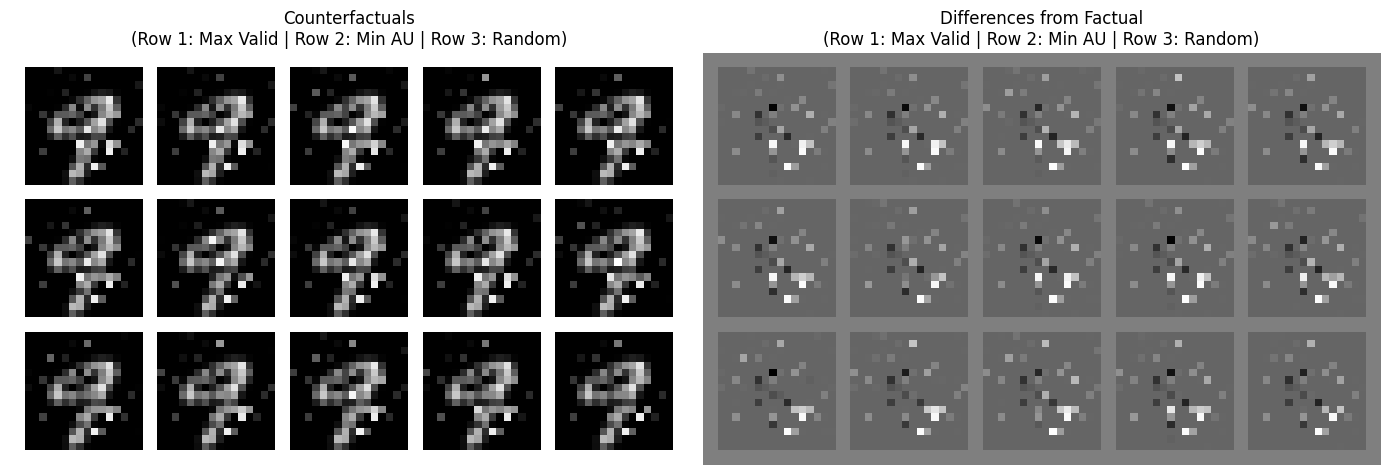

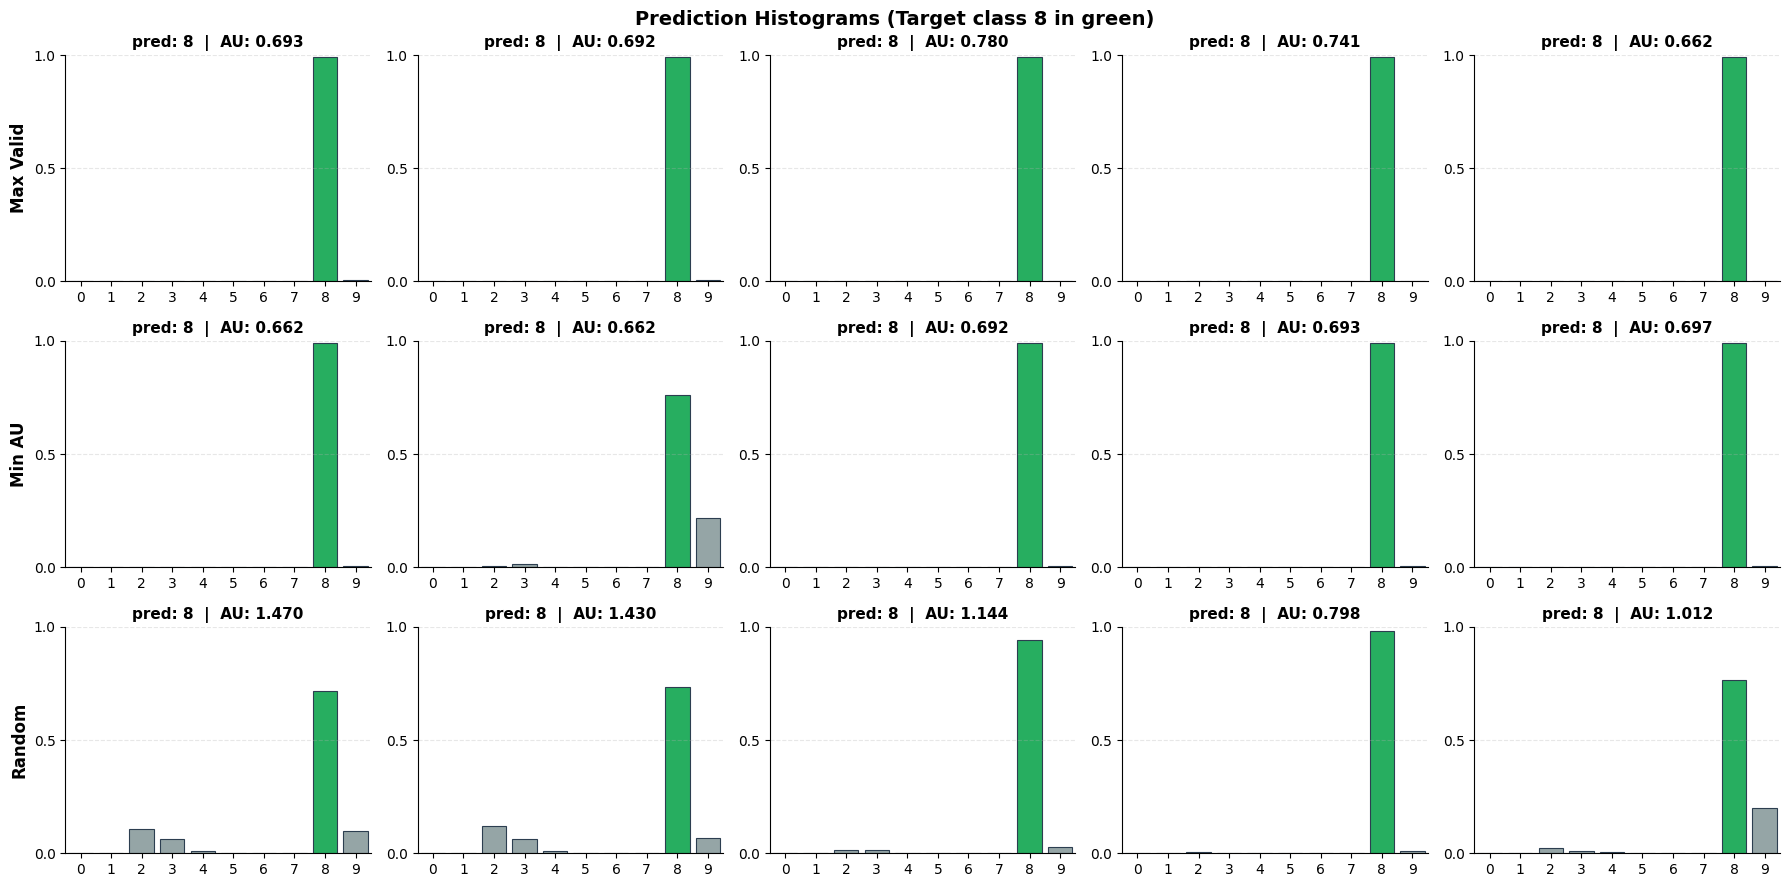


--- Objective Values [Validity, Epistemic, Sparsity, AU] ---

Max Valid:
  CF 1: pred=8, Valid=0.007, EU=0.223, Sparse=37, AU=0.693
  CF 2: pred=8, Valid=0.007, EU=0.219, Sparse=39, AU=0.692
  CF 3: pred=8, Valid=0.008, EU=0.231, Sparse=42, AU=0.780
  CF 4: pred=8, Valid=0.008, EU=0.207, Sparse=35, AU=0.741
  CF 5: pred=8, Valid=0.009, EU=0.190, Sparse=34, AU=0.662

Min AU:
  CF 1: pred=8, Valid=0.009, EU=0.190, Sparse=34, AU=0.662
  CF 2: pred=8, Valid=0.240, EU=0.139, Sparse=37, AU=0.662
  CF 3: pred=8, Valid=0.007, EU=0.219, Sparse=39, AU=0.692
  CF 4: pred=8, Valid=0.007, EU=0.223, Sparse=37, AU=0.693
  CF 5: pred=8, Valid=0.010, EU=0.192, Sparse=41, AU=0.697

Random:
  CF 1: pred=8, Valid=0.285, EU=0.305, Sparse=37, AU=1.470
  CF 2: pred=8, Valid=0.267, EU=0.313, Sparse=38, AU=1.430
  CF 3: pred=8, Valid=0.058, EU=0.294, Sparse=37, AU=1.144
  CF 4: pred=8, Valid=0.018, EU=0.191, Sparse=34, AU=0.798
  CF 5: pred=8, Valid=0.236, EU=0.215, Sparse=29, AU=1.012


In [11]:
# visualize three groups of counterfactual examples using torchvision make_grid
import numpy as np
from torchvision.utils import make_grid

num_to_display = 5  # per group

# Get valid indices (validity score < 0.3)
valid_indices = [i for i, f in enumerate(results.F) if f[0] < 0.3]
valid_X = results.X[valid_indices]
valid_F = results.F[valid_indices]

print(f"Total solutions: {len(results.F)}, Valid solutions: {len(valid_indices)}")

# With ensemble, objectives are: [Validity, Epistemic, Sparsity, -AU]
print(f"Objective shape: {results.F.shape[1]} objectives")
print(f"Objectives: [Validity, Epistemic, Sparsity, -AU]")
print(f"Sample objective values: {results.F[0]}")

# Group 1: Max Valid (sorted by validity - lowest first, i.e., most valid)
sorted_by_validity = np.argsort(valid_F[:, 0])
group1_indices = [valid_indices[i] for i in sorted_by_validity[:num_to_display]]

# Group 2: Min AU (objective index 3 is -AU, so HIGHEST -AU = lowest AU)
sorted_by_au_desc = np.argsort(-valid_F[:, 3])
group2_indices = [valid_indices[i] for i in sorted_by_au_desc[:num_to_display]]

# Group 3: Random choice from valid
random_choice = np.random.choice(len(valid_indices), size=min(num_to_display, len(valid_indices)), replace=False)
group3_indices = [valid_indices[i] for i in random_choice]

groups = [
    ("Max Valid", group1_indices),
    ("Min AU", group2_indices),
    ("Random", group3_indices)
]

# Collect all images for the grid
all_cf_images = []
all_diff_images = []

for g_idx, (group_name, selected_indices) in enumerate(groups):
    for i in range(min(num_to_display, len(selected_indices))):
        idx = selected_indices[i]
        cf_example = results.X[idx].reshape(1, IMG_SIZE, IMG_SIZE)
        cf_tensor = torch.tensor(cf_example, dtype=torch.float32)
        all_cf_images.append(cf_tensor)
        
        # Compute difference
        diff = cf_example - x_factual.reshape(1, IMG_SIZE, IMG_SIZE).cpu().numpy()
        diff_tensor = torch.tensor(diff, dtype=torch.float32)
        all_diff_images.append(diff_tensor)

# Stack and create grids
cf_stack = torch.stack(all_cf_images)
diff_stack = torch.stack(all_diff_images)

# Create grids (3 rows for 3 groups, num_to_display columns)
cf_grid = make_grid(cf_stack, nrow=num_to_display, normalize=True, padding=2, pad_value=1)
diff_grid = make_grid(diff_stack, nrow=num_to_display, normalize=True, padding=2, pad_value=0.5)

# Plot CF and Diff grids
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 8))

axes1[0].imshow(cf_grid.permute(1, 2, 0).numpy(), cmap='gray')
axes1[0].set_title('Counterfactuals\n(Row 1: Max Valid | Row 2: Min AU | Row 3: Random)', fontsize=12)
axes1[0].axis('off')

axes1[1].imshow(diff_grid.permute(1, 2, 0).numpy(), cmap='bwr')
axes1[1].set_title('Differences from Factual\n(Row 1: Max Valid | Row 2: Min AU | Row 3: Random)', fontsize=12)
axes1[1].axis('off')

plt.tight_layout()
plt.show()

# Plot histogram grid using matplotlib subplots (much clearer)
fig2, axes2 = plt.subplots(3, num_to_display, figsize=(18, 9))

row_labels = ["Max Valid", "Min AU", "Random"]

for g_idx, (group_name, selected_indices) in enumerate(groups):
    for i in range(min(num_to_display, len(selected_indices))):
        idx = selected_indices[i]
        cf_input = torch.tensor(results.X[idx].reshape(1, 1, IMG_SIZE, IMG_SIZE), dtype=torch.float32, device=device)
        
        with torch.no_grad():
            probs = nn.functional.softmax(models[0](cf_input), dim=1).squeeze().cpu().numpy()
        
        pred = probs.argmax()
        obj_vals = results.F[idx]
        au_value = -obj_vals[3]
        
        # Create histogram
        ax = axes2[g_idx, i]
        colors = ['#27ae60' if j == target_class else '#95a5a6' for j in range(10)]
        ax.bar(range(10), probs, color=colors, edgecolor='#2c3e50', linewidth=0.8)
        ax.set_ylim(0, 1)
        ax.set_xlim(-0.5, 9.5)
        ax.set_xticks(range(10))
        ax.set_yticks([0, 0.5, 1])
        ax.tick_params(axis='both', labelsize=10)
        ax.set_title(f'pred: {pred}  |  AU: {au_value:.3f}', fontsize=11, fontweight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add row label on first column
        if i == 0:
            ax.set_ylabel(row_labels[g_idx], fontsize=12, fontweight='bold')

plt.suptitle(f'Prediction Histograms (Target class {target_class} in green)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Print objective values for each group
print("\n--- Objective Values [Validity, Epistemic, Sparsity, AU] ---")
for g_idx, (group_name, selected_indices) in enumerate(groups):
    print(f"\n{group_name}:")
    for i, idx in enumerate(selected_indices[:num_to_display]):
        obj_vals = results.F[idx]
        cf_tensor = torch.tensor(results.X[idx].reshape(1, 1, IMG_SIZE, IMG_SIZE), dtype=torch.float32, device=device)
        pred = models[0](cf_tensor).argmax().item()
        au_value = -obj_vals[3]
        print(f"  CF {i+1}: pred={pred}, Valid={obj_vals[0]:.3f}, EU={obj_vals[1]:.3f}, Sparse={obj_vals[2]:.0f}, AU={au_value:.3f}")

In [10]:
from utils import plot_cf_3d
plot_cf_3d(results, x_factual.view(-1).cpu().numpy(), context=DG.sample(5000, seed=5678)[0].reshape(5000, -1).cpu().numpy())